# Import Libraries

In [107]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Obtain Data

Read csv with happiness data into Pandas

In [61]:
df = pd.read_csv('Data/world-happiness-report.csv')
df.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258
1,Afghanistan,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237
2,Afghanistan,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275
3,Afghanistan,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267
4,Afghanistan,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268


# Scrub Data

Calculate number of datapoints by year in order to determine which year to use for modeling

In [62]:
df.groupby('year').count()['Country name']

year
2005     27
2006     89
2007    102
2008    110
2009    114
2010    124
2011    146
2012    142
2013    137
2014    145
2015    143
2016    142
2017    147
2018    142
2019    144
2020     95
Name: Country name, dtype: int64

Use data for 2017 in modeling and drop data for all other years from the df

In [63]:
df = df[df['year']==2017]
df.reset_index(drop=True, inplace=True)
df.drop(columns='year', inplace=True)
df.head()

,Country name,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2.662,7.697,0.491,52.8,0.427,-0.121,0.954,0.496,0.371
1,Albania,4.640,9.476,0.638,68.4,0.750,-0.029,0.876,0.669,0.334
2,Algeria,5.249,9.354,0.807,65.7,0.437,-0.167,0.700,0.642,0.289
3,Argentina,6.039,10.067,0.907,68.6,0.832,-0.186,0.841,0.809,0.292
4,Armenia,4.288,9.402,0.698,66.6,0.614,-0.147,0.865,0.625,0.437


use df.info() to determine what scrubbing needed

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      147 non-null    object 
 1   Life Ladder                       147 non-null    float64
 2   Log GDP per capita                146 non-null    float64
 3   Social support                    146 non-null    float64
 4   Healthy life expectancy at birth  143 non-null    float64
 5   Freedom to make life choices      146 non-null    float64
 6   Generosity                        145 non-null    float64
 7   Perceptions of corruption         137 non-null    float64
 8   Positive affect                   146 non-null    float64
 9   Negative affect                   146 non-null    float64
dtypes: float64(9), object(1)
memory usage: 11.6+ KB


Drop object variables and other variables not useful for modeling

In [65]:
df.drop(columns=['Country name', 'Positive affect', 'Negative affect'], inplace=True)
df.head()

,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption
0,2.662,7.697,0.491,52.8,0.427,-0.121,0.954
1,4.640,9.476,0.638,68.4,0.750,-0.029,0.876
2,5.249,9.354,0.807,65.7,0.437,-0.167,0.700
3,6.039,10.067,0.907,68.6,0.832,-0.186,0.841
4,4.288,9.402,0.698,66.6,0.614,-0.147,0.865


Replace missing values with knn imputer

In [66]:
knn_x = df.drop(columns='Life Ladder')
knn_imputer = KNNImputer()
imputed_x = pd.DataFrame(knn_imputer.fit_transform(knn_x), columns=knn_x.columns)
scrubbed_df = pd.concat([df[['Life Ladder']], imputed_x], axis=1)
scrubbed_df.head()

,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption
0,2.662,7.697,0.491,52.8,0.427,-0.121,0.954
1,4.640,9.476,0.638,68.4,0.750,-0.029,0.876
2,5.249,9.354,0.807,65.7,0.437,-0.167,0.700
3,6.039,10.067,0.907,68.6,0.832,-0.186,0.841
4,4.288,9.402,0.698,66.6,0.614,-0.147,0.865


Confirm data is now scrubbed with scrubbed_df.info()

In [67]:
scrubbed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Life Ladder                       147 non-null    float64
 1   Log GDP per capita                147 non-null    float64
 2   Social support                    147 non-null    float64
 3   Healthy life expectancy at birth  147 non-null    float64
 4   Freedom to make life choices      147 non-null    float64
 5   Generosity                        147 non-null    float64
 6   Perceptions of corruption         147 non-null    float64
dtypes: float64(7)
memory usage: 8.2 KB


# Explore Data

Use isolation forest to identify greatest 5% outliers

In [91]:
if_x = scrubbed_df.drop(columns='Life Ladder')
isf = IsolationForest(random_state=72, contamination=.05)
isf.fit(if_x)
if_x['Outlier'] = isf.predict(if_x)
outlier_indices = if_x[if_x['Outlier']==-1].index
if_x[if_x['Outlier']==-1]

,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Outlier
0,7.697,0.491,52.8,0.427,-0.121,0.954,-1
22,6.817,0.320,45.2,0.645,0.073,0.890,-1
47,10.278,0.753,72.2,0.438,-0.290,0.872,-1
50,7.475,0.647,55.5,0.484,0.381,0.647,-1
91,8.464,0.795,58.7,0.886,0.650,0.619,-1
111,7.588,0.517,60.5,0.908,0.051,0.214,-1
116,11.461,0.897,76.5,0.926,0.136,0.162,-1
141,8.782,0.942,64.8,0.985,0.123,0.465,-1


Confirm no need to drop any outliers by observing standard scaled datapoints for 5% greatest outliers

In [103]:
ss_x = if_x.drop(columns='Outlier')
ss = StandardScaler()
ss_x = pd.DataFrame(ss.fit_transform(ss_x), columns=ss_x.columns)
ss_x.iloc[outlier_indices]

,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption
0,-1.449950,-2.590515,-1.603502,-2.797319,-0.728799,1.248788
22,-2.200287,-3.999583,-2.679850,-1.074047,0.511142,0.889275
47,0.750753,-0.431594,1.144016,-2.710365,-1.808954,0.788162
50,-1.639239,-1.305051,-1.221116,-2.346739,2.479709,-0.475751
91,-0.795963,-0.085507,-0.767917,0.831038,4.199008,-0.633038
111,-1.542889,-2.376271,-0.512992,1.004946,0.370530,-2.908081
116,1.759444,0.754989,1.753002,1.147235,0.913803,-3.200185
141,-0.524819,1.125796,0.095994,1.613625,0.830715,-1.498116


Calculate descriptive statistics for all variables in scrubbed_df

In [104]:
scrubbed_df.describe()

,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption
count,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000
mean,5.460408,9.397512,0.805377,64.122197,0.780871,-0.006973,0.731693
std,1.140804,1.176817,0.121772,7.085058,0.126936,0.156994,0.178627
min,2.662000,6.817000,0.320000,45.200000,0.427000,-0.290000,0.162000
25%,4.619500,8.501000,0.733500,58.700000,0.713500,-0.135000,0.681500
50%,5.553000,9.491000,0.829000,65.800000,0.813000,-0.030000,0.781600
75%,6.251500,10.373000,0.905000,68.900000,0.884000,0.093000,0.851000
max,7.788000,11.634000,0.967000,76.500000,0.985000,0.650000,0.954000


Plot distributions of all variables

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

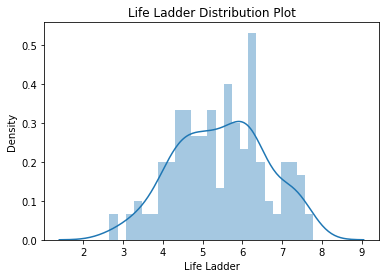

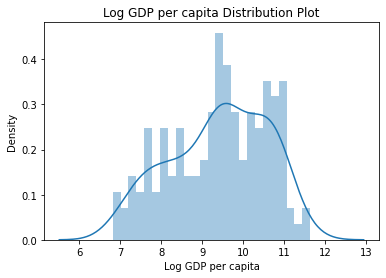

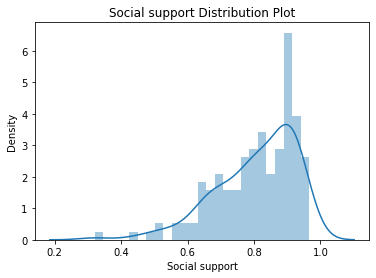

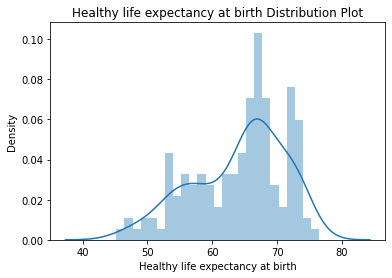

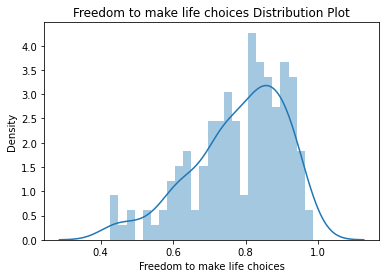

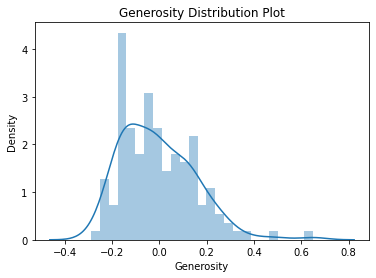

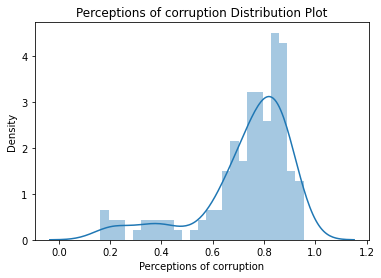

In [110]:
for var in scrubbed_df.columns:
    fig, ax = plt.subplots()
    sns.distplot(scrubbed_df[var], kde=True, bins=25, ax=ax)
    ax.set_title(f'{var} Distribution Plot')

Create pairplots to represent relationships between each x variable and the dependent variable

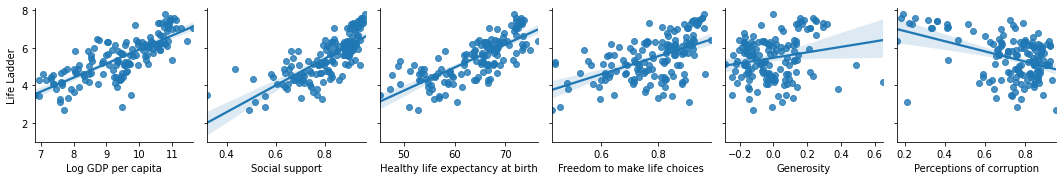

In [114]:
sns.pairplot(scrubbed_df, x_vars = x.columns, y_vars=['Life Ladder'], kind='reg')

# Model Data